In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !unzip /content/drive/MyDrive/Colab\ Notebooks/guava.zip -d /content/drive/MyDrive/Colab\ Notebooks/

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
BATCH_SIZE = 16
IMAGE_SIZE_X = 224
IMAGE_SIZE_Y = 224
NUM_CLASSES = 3
CHANNELS=3
EPOCHS=50

In [4]:
guava_dir = "/content/drive/MyDrive/Colab Notebooks/Guava+dataset"
guava_dataset_dir = "/content/drive/MyDrive/Colab Notebooks/Guava"

In [8]:
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.15, test_split=0.15, shuffle=True, shuffle_size=10000):
    assert (train_split + val_split + test_split) == 1

    ds_size = ds.cardinality().numpy()

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    test_size = int(test_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size).take(test_size)

    return train_ds, val_ds, test_ds

In [ ]:
guava_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    guava_dir,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE_X, IMAGE_SIZE_Y),
    batch_size=BATCH_SIZE
)

guava_plus_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    guava_dataset_dir,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE_X, IMAGE_SIZE_Y),
    batch_size=BATCH_SIZE
)

# Kết hợp cả hai dataset
combined_dataset = guava_dataset.concatenate(guava_plus_dataset)

# Tiến hành chia tập dữ liệu thành train, validation, test
train_ds, val_ds, test_ds = get_dataset_partitions_tf(combined_dataset)


Found 263 files belonging to 3 classes.
Found 212 files belonging to 3 classes.


In [10]:
class_names = guava_dataset.class_names  # Hoặc guava_plus_dataset.class_names
ds_size = combined_dataset.cardinality().numpy()
print(f"Total dataset size: {ds_size}")
print(f"Class names: {class_names}")

Total dataset size: 31
Class names: ['dot', 'healthy', 'rust']


In [11]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(combined_dataset)

print(f"Total images in train dataset: {train_ds.cardinality().numpy() * BATCH_SIZE}")
print(f"Total images in validation dataset: {val_ds.cardinality().numpy() * BATCH_SIZE}")
print(f"Total images in test dataset: {test_ds.cardinality().numpy() * BATCH_SIZE}");

Total images in train dataset: 336
Total images in validation dataset: 64
Total images in test dataset: 64


In [12]:
import os

# Đường dẫn đến thư mục chứa dữ liệu
guava_dir = "/content/drive/MyDrive/Colab Notebooks/Guava+dataset"
guava_dataset_dir = "/content/drive/MyDrive/Colab Notebooks/Guava"

# Kiểm tra số lượng hình ảnh trong từng class cho cả hai thư mục
for dataset_path in [guava_dir, guava_dataset_dir]:
    print(f"Checking dataset in: {dataset_path}")
    for class_name in os.listdir(dataset_path):
        class_dir = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_dir):  # Kiểm tra xem có phải là thư mục không
            num_images = len(os.listdir(class_dir))
            print(f"Class: {class_name}, Number of images: {num_images}")

Checking dataset in: /content/drive/MyDrive/Colab Notebooks/Guava+dataset
Class: dot, Number of images: 89
Class: rust, Number of images: 38
Class: healthy, Number of images: 136
Checking dataset in: /content/drive/MyDrive/Colab Notebooks/Guava
Class: rust, Number of images: 60
Class: healthy, Number of images: 67
Class: dot, Number of images: 85


In [13]:
import tensorflow as tf

# Áp dụng các phép biến đổi cho train dataset
train_ds = train_ds.map(lambda x, y: (tf.image.random_flip_left_right(x), y))
train_ds = train_ds.map(lambda x, y: (tf.image.random_flip_up_down(x), y))
train_ds = train_ds.map(lambda x, y: (tf.image.random_brightness(x, max_delta=0.2), y))
train_ds = train_ds.map(lambda x, y: (tf.image.random_contrast(x, lower=0.2, upper=0.5), y))


In [14]:
print(f"Number of batches in train dataset: {train_ds.cardinality().numpy()}")
print(f"Number of batches in validation dataset: {val_ds.cardinality().numpy()}")
print(f"Number of batches in test dataset: {test_ds.cardinality().numpy()}")

Number of batches in train dataset: 21
Number of batches in validation dataset: 4
Number of batches in test dataset: 4


In [15]:
len(train_ds)

21

In [16]:
len(val_ds)

4

In [17]:
len(test_ds)

4

In [18]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE_X, IMAGE_SIZE_Y),
  layers.Rescaling(1./255),
])

In [20]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Layer

class RandomBlur(Layer):
    def __init__(self, kernel_size=3, **kwargs):
        super(RandomBlur, self).__init__(**kwargs)
        self.kernel_size = kernel_size

    def call(self, images):
        channels = tf.shape(images)[-1]
        blur_kernel = tf.ones((self.kernel_size, self.kernel_size, channels, 1)) / (self.kernel_size ** 2)

        return tf.nn.depthwise_conv2d(
            images, blur_kernel,
            strides=[1, 1, 1, 1], padding='SAME'
        )

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),  # Tăng mức độ xoay ngẫu nhiên
    layers.RandomZoom(0.3),      # Tăng zoom
    layers.RandomBrightness((0.1, 0.3)),  # Thay đổi độ sáng rộng hơn
    layers.RandomContrast(0.1),           # Thay đổi độ tương phản
])



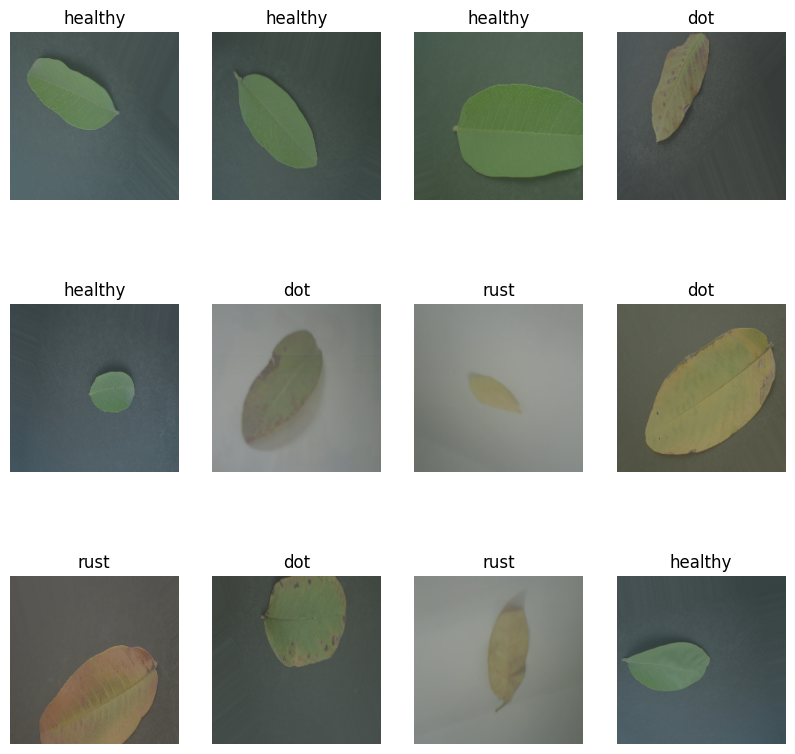

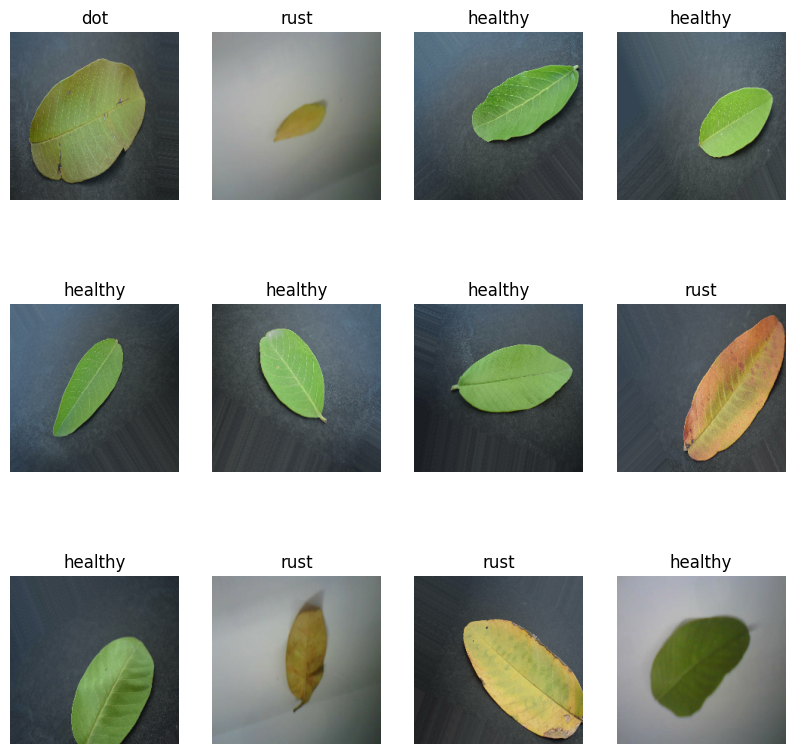

In [21]:
import matplotlib.pyplot as plt

for image_batch, labels_batch in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[labels_batch[i]])
    plt.axis("off")
  plt.show()
  break


for image_batch, labels_batch in combined_dataset.take(1):
  plt.figure(figsize=(10, 10))
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[labels_batch[i]])
    plt.axis("off")
  plt.show()
  break

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMAGE_SIZE_X, IMAGE_SIZE_Y, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))  # Tăng Dropout từ 0.4 lên 0.5

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))  # Giảm số filters từ 128 xuống 64
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))  # Giữ mức Dropout mạnh hơn

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))  # Giữ filters 64 thay vì tăng lên
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

# Fully connected layers
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))  # Giảm l2 từ 0.01 xuống 0.001
model.add(Dropout(0.5))  # Giữ mức Dropout cao
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))  # Giảm l2 từ 0.01 xuống 0.001
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      25,690,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,879,683 (98.72 MB)

 Trainable params: 25,879,363 (98.72 MB)

 Non-trainable params: 320 (1.25 KB)

In [ ]:
# model.compile(
#     optimizer='adam',
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
#     metrics=['accuracy']
# )

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# class_weights = {
#     0: 1.0,  # dot
#     1: 1.0,  # healthy
#     2: 1.0,  # mummification
#     3: 1.0   # rust
# }

earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose=1,
    restore_best_weights=True
)

# checkpoint = ModelCheckpoint(
#     '/content/guava-w-aug-esp32.h5',
#     monitor='val_loss',
#     save_best_only=True,
#     mode='min',
#     verbose=1
# )

# callbacks = [checkpoint, earlystop]
callbacks = [earlystop]

history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=47,
    # class_weight=class_weights,
    callbacks=callbacks
)
#Note : 47 epochs

Epoch 1/47
21/21 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.4058 - loss: 5.2026 - val_accuracy: 0.5636 - val_loss: 2.5596
Epoch 2/47
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.4500 - loss: 4.3806 - val_accuracy: 0.1818 - val_loss: 5.5050
Epoch 3/47
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.4930 - loss: 3.8348 - val_accuracy: 0.2727 - val_loss: 3.9481
Epoch 4/47
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5157 - loss: 3.8200 - val_accuracy: 0.4182 - val_loss: 2.6151
Epoch 5/47
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.4550 - loss: 3.5419 - val_accuracy: 0.3818 - val_loss: 2.8108
Epoch 6/47
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.5330 - loss: 2.9304 - val_accuracy: 0.5273 - val_loss: 2.4442
Epoch 7/47
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.5889 - loss: 2.7488 - val_accuracy: 0.4909 - val_loss: 2.3163
Epoch 8/47
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5084 - loss: 2.8053 - val_accuracy: 0.5273 - va

In [ ]:
# scores = model.evaluate(test_ds)

In [23]:
# scores

In [24]:
history

In [25]:
history.params

{'verbose': 1, 'epochs': 47, 'steps': 21}

In [26]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [27]:
type(history.history['loss'])

list

In [28]:
len(history.history['loss'])

35

In [29]:
history.history['loss'][:5]

[4.973004341125488,
 4.461215019226074,
 3.874654769897461,
 3.6613645553588867,
 3.406801700592041]

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

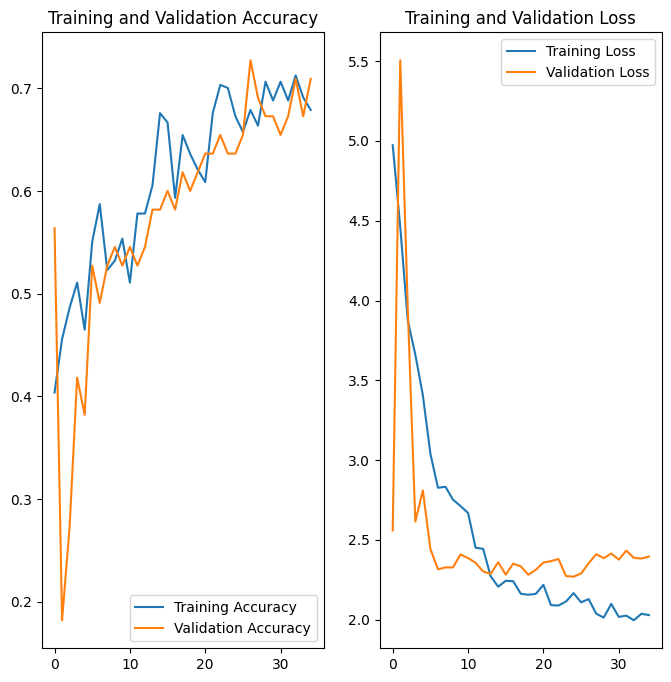

In [31]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(len(acc)), acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(len(loss)), loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [32]:
model.save('guava_model.keras')

first image to predict
actual label: healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
predicted label: healthy


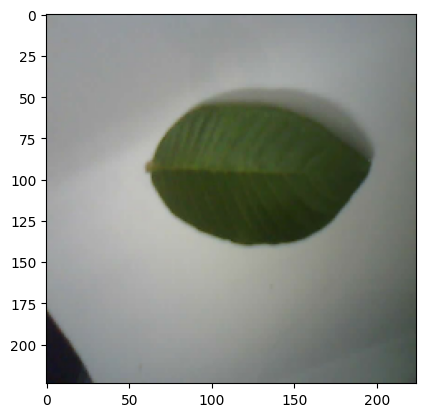

In [33]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [34]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Thêm chiều batch size

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    return predicted_class, confidence


In [35]:
model.save('/content/my_model.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


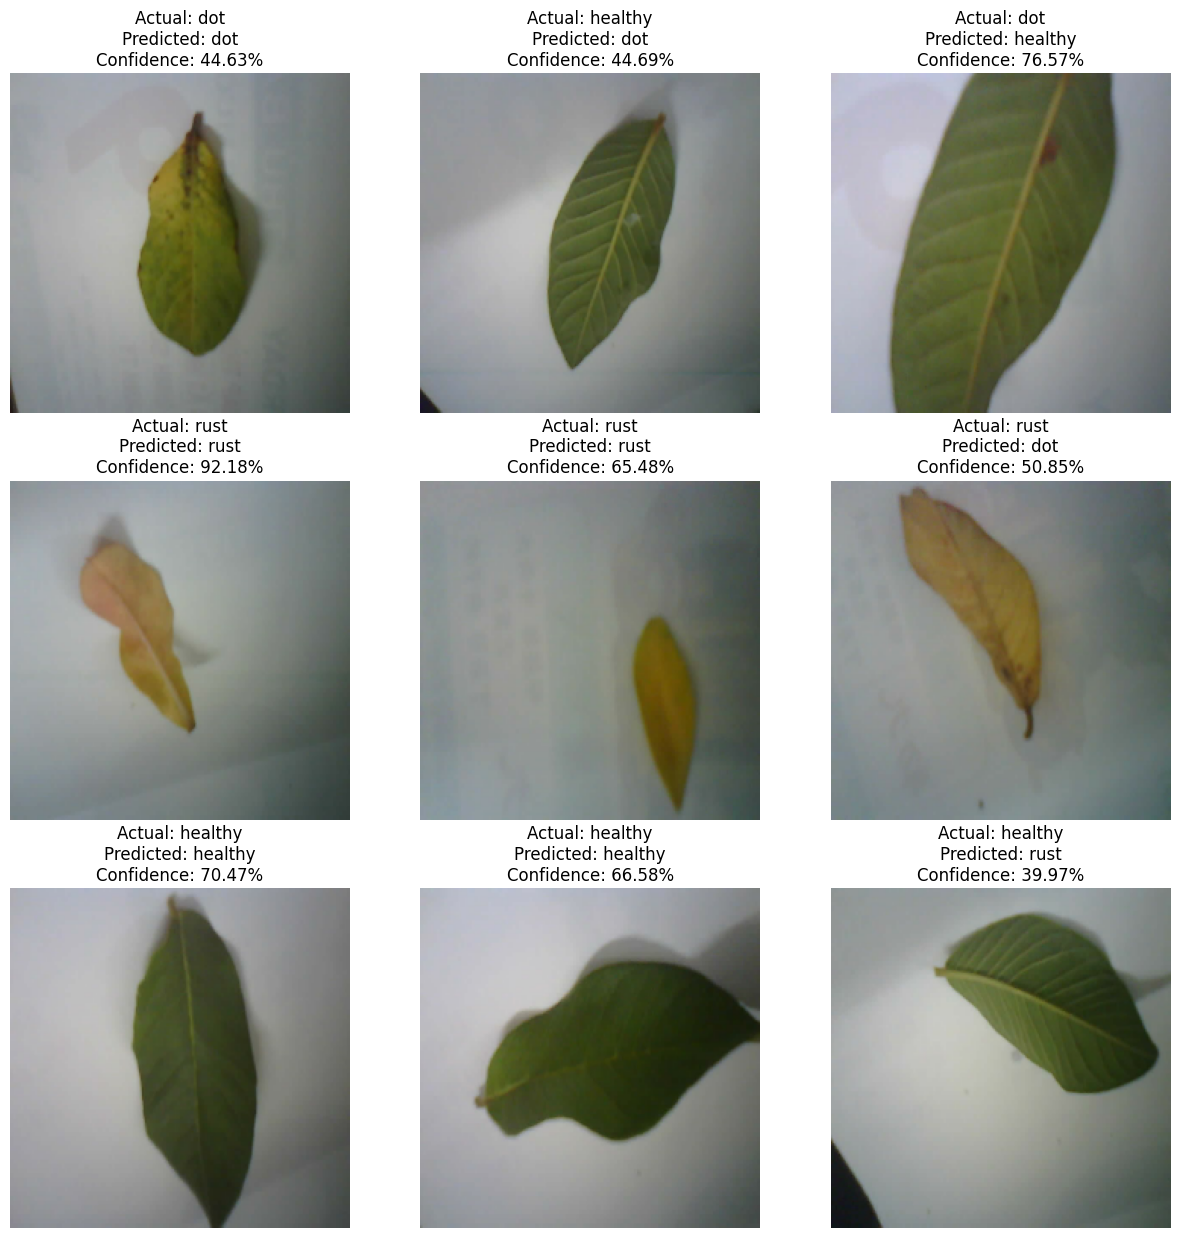

In [42]:
from tensorflow import keras

model = keras.models.load_model('/content/my_model.keras')
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(min(9, len(images))):  # Chỉ vẽ tối đa 9 ảnh
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%")
        plt.axis("off")
plt.show()

Saving 20241106191445.jpg to 20241106191445.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
Image: 20241106191445.jpg
Predicted class: dot
Confidence: 80.08%


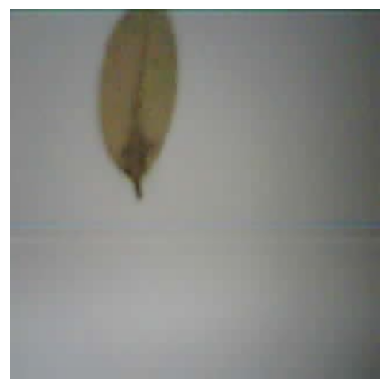

In [63]:

from google.colab import files
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

model = tf.keras.models.load_model('/content/guava_model.keras')

class_names = ['dot', 'healthy', 'rust']

uploaded = files.upload()

for fn in uploaded.keys():
  path = '/content/' + fn
  img = tf.keras.utils.load_img(path, target_size=(224, 224))
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)
  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])), 2)

  print(f"Image: {fn}")
  print(f"Predicted class: {predicted_class}")
  print(f"Confidence: {confidence}%")
  plt.imshow(img)
  plt.axis('off')
  plt.show()

In [38]:
# Tạo thư mục nếu chưa tồn tại
os.makedirs(model_directory, exist_ok=True)

NameError: name 'model_directory' is not defined

In [ ]:
import os

# Lọc ra các tệp có phần mở rộng .h5 và chỉ lấy phần tên tệp (không có phần mở rộng)
model_files = [f.split('.')[0] for f in os.listdir("/content/model") if f.endswith(".h5")]

# Chuyển đổi các tên tệp thành số nguyên, bỏ qua các tệp không phải số nguyên
model_versions = [int(f) for f in model_files if f.isdigit()]

# Tìm số phiên bản lớn nhất và cộng thêm 1
model_version = max(model_versions, default=0) + 1

# Lưu mô hình với tên phiên bản mới
model.save(f"/content/model/{model_version}.h5")
print(f"Model saved as /content/model/{model_version}.h5")


Use trained model


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


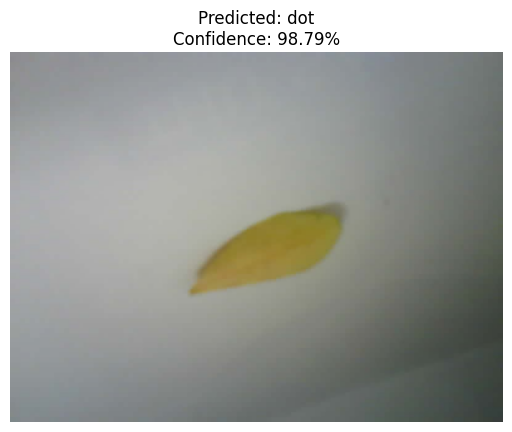

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

# Đường dẫn đến mô hình đã lưu
model_path = "/content/model/1.h5"
model = tf.keras.models.load_model(model_path)

# Các lớp của mô hình
class_names = ['dot', 'healthy', 'rust']

# Hàm xử lý ảnh
def preprocess_image(image_path):
    img = tf.keras.utils.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    img_array /= 255.0
    return img_array

# Hàm dự đoán
def predict_image(image_path):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file not found at {image_path}")

    img_array = preprocess_image(image_path)
    prediction = model.predict(img_array)

    predicted_class = class_names[np.argmax(prediction[0])]
    confidence = round(100 * np.max(prediction[0]), 2)
    return predicted_class, confidence

# Đường dẫn ảnh cần dự đoán
image_path = "/content/drive/MyDrive/Colab Notebooks/Guava/rust/20241111164713.jpg"  # Đảm bảo tệp tồn tại

# Dự đoán và hiển thị ảnh
try:
    predicted_class, confidence = predict_image(image_path)
    img = tf.keras.utils.load_img(image_path)
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence}%")
    plt.axis("off")
    plt.show()
except FileNotFoundError as e:
    print(e)
